Enter your prompt and image. Please enter the image in link only.

In [1]:
prompt = "Show me similar products"
image = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcT1tA1mlzhdXgQHH37d2HfBRhnVMRCbhFQ1JSmbXciU-IxExwhVkGKGtI8_r_DCYYdSYKg&usqp=CAU" ## Please paste link of image and not the address in colab document

Installations

In [2]:
!pip install duckduckgo-search
!pip install tenacity

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 25.1 MB/s eta 0:00:00


Imports

In [3]:
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoModel
from PIL import Image
import torch
import requests
from io import BytesIO
from transformers import CLIPProcessor, CLIPModel, AutoFeatureExtractor, AutoModel
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from urllib.parse import urljoin
from duckduckgo_search import DDGS
from tenacity import retry, wait_fixed, stop_after_attempt

It takes the final query i.e., after merging image description and prompt you entered above. And searches in using serapi web search using `yahoo_domain` not google. Don't just look at `GoogleSearch` function. It then returns the whole searched result.

In [8]:
# Add retry mechanism to perform_web_search
@retry(wait=wait_fixed(14), stop=stop_after_attempt(3)) # Retry 3 times with 2 seconds delay
def perform_web_search(query):
    results = DDGS().text(query, max_results=5)
    return results

This is the `moondream2` model that describes the image given to it.

And, i am using a function `main` that merges the prompt and the image description, and searches that string on the web search function above and return the search results.

In [9]:
model_id = "vikhyatk/moondream2"
revision = "2024-08-26"
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    revision=revision,
    trust_remote_code=True,
    torch_dtype=torch.float16,
).eval().to("cuda")
tokenizer = AutoTokenizer.from_pretrained(model_id, revision=revision)

def main(image_path, prompt):
    # # Preprocess the image
    image = Image.open(BytesIO(requests.get(image_path).content))
    enc_image = model.encode_image(image).to("cuda")

    pro = model.answer_question(enc_image, "Describe this image", tokenizer)

    # For the sake of this example, we are using the prompt directly for searching
    prompt = prompt + ' of ' + pro.replace("The image shows ", '').replace("A person is ", '')
    print("Prompt that gonna be searched on web: ", prompt)
    search_results = perform_web_search(prompt)

    return search_results, prompt


results, search_query = main(image, prompt)

Prompt that gonna be searched on web:  Show me similar products of a can of Red Bull energy drink with a blue and white color scheme.


#### Processing search results and separated all links, title and body from all values in search results.

In [10]:
display_results = []
for i in results:
    display_results.append({'title': i['title'], 'href': i['href'], 'body': i['body']})
print(display_results)

[{'title': 'Red Bull Blue Edition Review (All You Need To Know)', 'href': 'https://beastlyenergy.com/red-bull-blue-edition-review/', 'body': "Red Bull Blue Edition Review. The Blue Edition of Red Bull comes in a blue can and deep purple colored drink. You'll see that this edition also has the same stimulants and nutrients that other variants contain. There are two serving sizes, 8.4 fl.oz, and 12 fl.oz, so you can choose which one works best for you."}, {'title': 'Red Bull Blue Energy Drink: Blueberry Edition | Red Bull', 'href': 'https://www.redbull.com/us-en/energydrink/red-bull-blue-edition', 'body': 'The Red Bull Blue Edition. A classic, with the fruity taste of blueberry*. *artificially flavored. The formula of Red Bull Energy Drink contains a unique combination of high quality ingredients ...'}, {'title': 'Red Bull Blue Edition Blueberry Energy Drink, 8.4 Fl Oz, 24 Cans (6 ...', 'href': 'https://www.amazon.com/Red-Bull-Energy-Drink-Blueberry/dp/B00CQUS6BW', 'body': 'Red Bull Blue

- I am using two models "CLIP" and "DINO".
- Both will help search similar images, it will taking two inputs, i.e., image given by user and web search results.
- Now web search will return many images and we will get here similar images from all images present in a website. So this will return most_similar_image from each website link.

In [11]:
# Load CLIP and DINO models
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch16")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16")
dino_model = AutoModel.from_pretrained("facebook/dino-vits16")
dino_feature_extractor = AutoFeatureExtractor.from_pretrained("facebook/dino-vits16")

def get_clip_image_features(image):
    # Preprocess and extract features using CLIP
    inputs = clip_processor(images=image, return_tensors="pt")
    with torch.no_grad():
        image_features = clip_model.get_image_features(**inputs)
    return image_features

def get_dino_image_features(image):
    # Preprocess and extract features using DINO
    inputs = dino_feature_extractor(images=image, return_tensors="pt")
    with torch.no_grad():
        image_features = dino_model(**inputs).last_hidden_state.mean(dim=1)
    return image_features

def cosine_similarity(embedding1, embedding2):
    # Compute cosine similarity between two image embeddings
    embedding1 = embedding1 / embedding1.norm(dim=-1, keepdim=True)
    embedding2 = embedding2 / embedding2.norm(dim=-1, keepdim=True)
    similarity = torch.matmul(embedding1, embedding2.T)
    return similarity

def find_most_similar_image(image_path, candidate_images, model="clip"):
    # Open and preprocess the target image
    image = Image.open(requests.get(image_path, stream=True).raw)

    if model == "clip":
        target_image_features = get_clip_image_features(image)
        candidate_features = [get_clip_image_features(Image.open(requests.get(img, stream=True).raw)) for img in candidate_images]
    elif model == "dino":
        target_image_features = get_dino_image_features(image)
        candidate_features = [get_dino_image_features(Image.open(img)) for img in candidate_images]

    # Compute similarities with each candidate image
    similarities = [cosine_similarity(target_image_features, candidate_feature) for candidate_feature in candidate_features]

    # Find the image with the highest similarity
    most_similar_idx = torch.argmax(torch.tensor(similarities))
    most_similar_image = candidate_images[most_similar_idx]

    return most_similar_image, similarities[most_similar_idx]


config.json:   0%|          | 0.00/4.10k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/599M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/453 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/86.7M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vits16 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preprocessor_config.json:   0%|          | 0.00/244 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


This function just shows the image in terminal or output screen by taking url.

In [12]:
def show_image(url):
    try:
        response = requests.get(url, timeout=10)  # Adjust timeout as needed
        response.raise_for_status()

        image_data = response.content
        image = Image.open(BytesIO(image_data))
        plt.imshow(image)
        plt.axis('off')
        plt.show()
    except requests.exceptions.RequestException as e:
        print(f"Error downloading image: {e}")

### This function takes website url and returns image urls of default at_max 15 images from the website url.

In [13]:
# def find_image_urls(url):
#     try:
#         response = requests.get(url, timeout=10)
#         response.raise_for_status()

#         soup = BeautifulSoup(response.content, 'html.parser')
#         image_tags = soup.find_all('img')

#         image_urls = []
#         for img in image_tags:
#             # Check if 'src' attribute exists before accessing
#             if 'src' in img.attrs:
#                 image_urls.append(img['src'])
#             # If not you can use the 'data-src' tag
#             # Add checks for other potential image url attributes
#             elif 'data-src' in img.attrs:
#                 image_urls.append(img['data-src'])

#         return image_urls
#     except requests.exceptions.RequestException as e:
#         print(f"Error fetching HTML: {e}")
#         return []

def find_image_urls(website_url, max_images=15):
    # List to store image URLs
    image_urls = []

    try:
        # Send a GET request to the website
        response = requests.get(website_url)
        response.raise_for_status()  # Raise an exception for bad status codes

        # Parse the HTML content
        soup = BeautifulSoup(response.text, 'html.parser')

        # Find all img tags
        img_tags = soup.find_all('img')

        # Extract and process image URLs
        for img in img_tags:
            # Get the 'src' attribute of the img tag
            img_url = img.get('src')

            # If src is None, try getting the 'data-src' attribute
            if img_url is None:
                img_url = img.get('data-src')

            # Skip if no valid URL found
            if img_url is None:
                continue

            # Make the URL absolute by joining it with the base URL
            img_url = urljoin(website_url, img_url)

            # Add the URL to our list
            if img_url not in image_urls:
                image_urls.append(img_url)

            # Break if we've reached the maximum number of images
            if len(image_urls) >= max_images:
                break

    except requests.RequestException as e:
        print(f"An error occurred while fetching the website: {e}")

    return image_urls[:max_images]

### Now this will return the most similar image from the image urls got from previous function, based on the user input image. Also it returns a similarity score of the most similar image.

In [14]:
def get_similar_image(url, actual_image, model):
    image_urls = find_image_urls(url)

    # Example usage
    target_image_path = actual_image  # Path to the image you're comparing
    candidate_image_paths = image_urls  # Paths to candidate images

    # You can switch between "clip" and "dino"
    try:
        most_similar_image, similarity_score = find_most_similar_image(target_image_path, candidate_image_paths, model=model)
    except:
        return None, None
    return most_similar_image, similarity_score

### Showing results of whole PS 1.

- #### contains multiple search outpus, and and showing product image, title, description, similarity score and features found similar.

Results of final Query:
Show me similar products of a can of Red Bull energy drink with a blue and white color scheme.


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


1. Title:  Red Bull Blue Edition Review (All You Need To Know)
   Description:  Red Bull Blue Edition Review. The Blue Edition of Red Bull comes in a blue can and deep purple colored drink. You'll see that this edition also has the same stimulants and nutrients that other variants contain. There are two serving sizes, 8.4 fl.oz, and 12 fl.oz, so you can choose which one works best for you.
   Similarity Score of Image Searched:  tensor([[0.6600]])


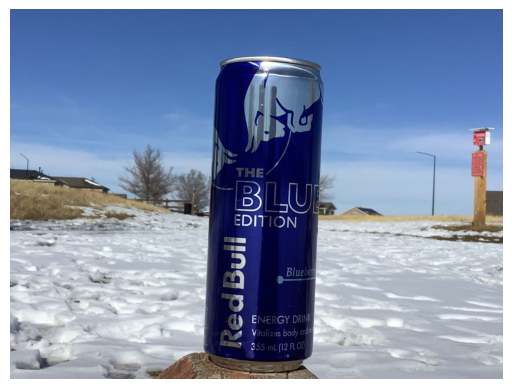

2. Title:  Red Bull Blue Energy Drink: Blueberry Edition | Red Bull
   Description:  The Red Bull Blue Edition. A classic, with the fruity taste of blueberry*. *artificially flavored. The formula of Red Bull Energy Drink contains a unique combination of high quality ingredients ...
   Similarity Score of Image Searched:  tensor([[0.9129]])


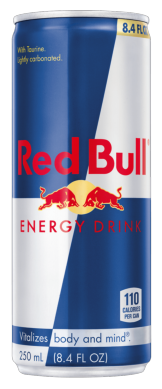

The channel dimension is ambiguous. Got image shape (1, 1, 3). Assuming channels are the first dimension.


3. Title:  Red Bull Blue Edition Blueberry Energy Drink, 8.4 Fl Oz, 24 Cans (6 ...
   URL to Refer (Sorry couldn't load images):  https://www.amazon.com/Red-Bull-Energy-Drink-Blueberry/dp/B00CQUS6BW
   Description:  Red Bull Blue Edition features the classic Red Bull formula of high-quality ingredients with the fruity taste of blueberry ; Each 8.4 fl oz can of Red Bull Blue Edition contains 80 mg of caffeine per serving, about the same amount of caffeine as a home-brewed cup of coffee ; One 8.4 fl oz can of Red Bull Blue Edition energy drink contains 27 g ...
   Similarity Score of Image Searched:  None
4. Title:  Red Bull Blue Edition Blueberry Energy Drink - 12 fl oz Can
   Description:  One 12 fl oz can of Red Bull Blue Edition, Blueberry contains 114 mg of caffeine, about the same amount as in an equal serving of home-brewed coffee. Red Bull Blue Edition Energy Drinks are: Wheat-free, gluten-free, dairy-free, lactose-free, vegetarian. Red Bull cans are made of 100% recyclable alumi

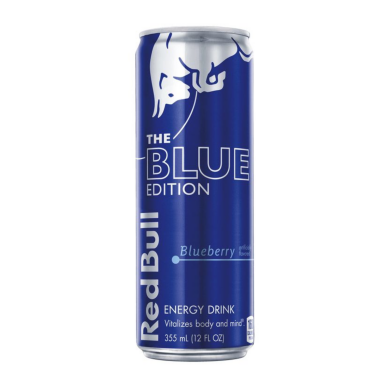

The channel dimension is ambiguous. Got image shape (1, 1, 3). Assuming channels are the first dimension.


5. Title:  Red Bull Blue Edition Energy Drink, Blueberry, with 114mg Caffeine plus ...
   URL to Refer (Sorry couldn't load images):  https://www.amazon.com/Red-Bull-Energy-Drink-Blue/dp/B07ZJ2VKMR
   Description:  Red Bull Sea Blue Edition Energy Drink, Juneberry, with 114mg Caffeine plus Taurine & B Vitamins, 12 Fl Oz, Pack of 4 Cans $9.99 $ 9 . 99 ($0.21/Fl Oz) Get it as soon as Wednesday, Sep 4
   Similarity Score of Image Searched:  None


In [15]:
print("Results of final Query:")
print(search_query)
st = 1
for i in display_results:
    img, score = get_similar_image(i['href'], image, "clip")
    print(st, end=". ")
    st += 1
    print("Title: ", i['title'])
    if(img == None):
        print("   URL to Refer (Sorry couldn't load images): ", i['href'])
    print("   Description: ", i['body'])
    print("   Similarity Score of Image Searched: ", score)
    if(img != None):
        show_image(img)